In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install gymnasium matplotlib numpy optuna
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import optuna
from collections import defaultdict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

AGENT_POS= [0, 3]
STAR_POS= [1, 0]
MASHROOM_POS= [3, 2]
BOO_POS= [1, 1]
BOMB_POS= [2, 2]
GOAL_POS= [3, 0]

In [ ]:
STATE_LOCATION = {(i, j): k for k, (i, j) in enumerate([(i, j) for i in range(4) for j in range(4)])}

In [ ]:
class SuperMarioEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 50

        self.timestep = 0

        self.agent_pos = AGENT_POS.copy()
        self.goal_pos = GOAL_POS.copy()
        self.star_pos = STAR_POS.copy()
        self.mashroom_pos = MASHROOM_POS.copy()
        self.boo_pos = BOO_POS.copy()
        self.bomb_pos = BOMB_POS.copy()


        self.star_awarded, self.mashroom_awarded,self.boo_awarded,self.bomb_awarded = False,False,False,False

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10



        self.goal_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/princess.jpeg')

        self.agent_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mario.png')

        self.star_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mario-star.jpeg')
        self.mashroom_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mashroom.png')
        self.boo_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/boo.jpeg')
        self.bomb_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/bomb.jpeg')

        
    def reset(self, **kwargs):

        self.timestep = 0
        
        self.agent_pos = AGENT_POS.copy()
        self.goal_pos = GOAL_POS.copy()
        self.star_pos = STAR_POS.copy()
        self.mashroom_pos = MASHROOM_POS.copy()
        self.boo_pos = BOO_POS.copy()
        self.bomb_pos = BOMB_POS.copy()

        self.star_awarded, self.mashroom_awarded,self.boo_awarded,self.bomb_awarded = False, False, False, False

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10

        observation = self.state.flatten()

        info = {}

        return observation, info, STATE_LOCATION[tuple(self.agent_pos)]
    
    def step(self, action):

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10

        observation = self.state.flatten()
        
        reward = 0
        if (self.agent_pos == self.star_pos).all():
          if not self.star_awarded:
            reward += 6
            self.star_awarded = True
        if (self.agent_pos == self.mashroom_pos).all():
          if not self.mashroom_awarded:
            reward += 5
            self.mashroom_awarded = True
        
        if (self.agent_pos == self.boo_pos).all():

          if not self.boo_awarded:
            reward -= 5
            self.boo_awarded = True
        
        if (self.agent_pos == self.bomb_pos).all():
          if not self.bomb_awarded:
            reward -= 6
            self.bomb_awarded = True
        
        if (self.agent_pos == self.goal_pos).all():
          reward += 10
        
        #print(reward)
        
        self.timestep += 1

        terminated = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
        
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        info = {}
        
        #return observation, reward, terminated, truncated, info, self.agent_pos

        return STATE_LOCATION[tuple(self.agent_pos)],reward, terminated, info, self.agent_pos
        
    def render(self):

        #plt.imshow(self.state)
        fig, ax = plt.subplots()

        
        ax.imshow(self.agent_img, extent=[self.agent_pos[1], self.agent_pos[1]+1, self.state.shape[0]-self.agent_pos[0]-1, self.state.shape[0]-self.agent_pos[0]])

        ax.imshow(self.goal_img, extent=[self.goal_pos[1], self.goal_pos[1]+1, self.state.shape[0]-self.goal_pos[0]-1, self.state.shape[0]-self.goal_pos[0]])

        if not self.star_awarded:
          ax.imshow(self.star_img, extent=[self.star_pos[1], self.star_pos[1]+1, self.state.shape[0]-self.star_pos[0]-1, self.state.shape[0]-self.star_pos[0]])
        if not self.mashroom_awarded:
          ax.imshow(self.mashroom_img, extent=[self.mashroom_pos[1], self.mashroom_pos[1]+1, self.state.shape[0]-self.mashroom_pos[0]-1, self.state.shape[0]-self.mashroom_pos[0]])
        if not self.boo_awarded:
          ax.imshow(self.boo_img, extent=[self.boo_pos[1], self.boo_pos[1]+1, self.state.shape[0]-self.boo_pos[0]-1, self.state.shape[0]-self.boo_pos[0]])
        if not self.bomb_awarded:
          ax.imshow(self.bomb_img, extent=[self.bomb_pos[1], self.bomb_pos[1]+1, self.state.shape[0]-self.bomb_pos[0]-1, self.state.shape[0]-self.bomb_pos[0]])


        
        ax.set_xlim([0, self.state.shape[1]])
        ax.set_ylim([0, self.state.shape[0]])
        plt.show()

In [ ]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

## SARSA Bootstraping

In [ ]:
class nStepSARSA(RandomAgent):
    
    def __init__(self, env, discount_rate, learning_rate, epsilon):
        super().__init__(env)

        self.epsilon= epsilon
        self.gamma= discount_rate
        self.alpha= learning_rate
        self.Q = np.zeros((self.observation_space.n, self.action_space.n))
        self.N = np.zeros((self.observation_space.n, self.action_space.n))
        self.prev_state = None
        self.prev_action = None

    def step(self, state:int):
        Q_state= self.Q[state]
        greedy_action= np.argmax(Q_state)
        random_action= super().step(state)

        return random_action if np.random.random() < self.epsilon else greedy_action

    # def train(self, experience: tuple):
    #     state, action, next_state, next_action, reward, done = experience
    #     next_Q = self.Q[next_state, next_action]
    #     if not done:
    #         next_next_action = self.step(next_state)
    #         next_next_Q = self.Q[next_state, next_next_action]
    #         next_Q = reward + self.gamma * next_next_Q
    #     target = next_Q * (1 - int(done)) + reward * int(done)
    #     error = target - self.Q[state, action]
    #     self.Q[state, action] += self.alpha * error
    #     if done:
    #         self.epsilon *= 0.99
    def train(self, experience):
      state, action, next_state, next_action, reward, done = experience
      
      next_Q = self.Q[next_state, next_action]
      if not done:
          next_next_action = self.step(next_state)
          next_next_Q = self.Q[next_state, next_next_action]
          next_Q += self.gamma * next_next_Q

      target = reward + self.gamma * next_Q * (1 - done)
      self.Q[state, action] += self.alpha * (target - self.Q[state, action])


      if done:
          self.epsilon *= 0.99


In [ ]:
configs = [
    {'episodes':500, 'discount_rate' : 0.9, 'learning_rate' : 0.1, 'epsilon':0.9},
]

In [ ]:

superMario = SuperMarioEnvironment()
SARSA_2Step_agent = nStepSARSA(env= superMario, discount_rate = configs[0]['discount_rate'], learning_rate = configs[0]['learning_rate'], epsilon= configs[0]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[0]['episodes']):
  
  state = superMario.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action = SARSA_2Step_agent.step(state = state)
  while not done:
    

    next_state, reward, done, info, _= superMario.step(action = action)
    next_action= SARSA_2Step_agent.step(state= next_state)

    SARSA_2Step_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(SARSA_2Step_agent.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario.timestep < 50:
    reached += 1
  elif done == True and superMario.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))


Goal Reached: 93 & Goal Not reached: 407


Text(0, 0.5, 'Reward')

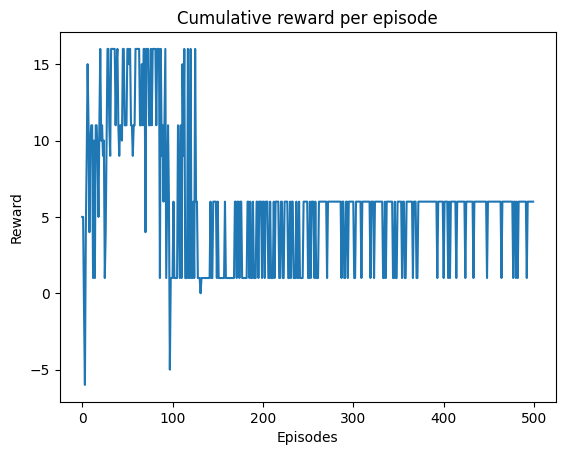

In [ ]:
plt.title('Cumulative reward per episode')
plt.plot(episode_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Reward')

# SARSA worked efficiently better than 2 step SARSA.


1.   SARSA worked efficiently while collecting rewards for this particular problem.

